# 학습 목표
1. 분자 동역학 시뮬레이션의 기본 개념 이해
2. ORB 모델을 이용한 단백질 시뮬레이션 설정 방법 학습
3. 제약 조건을 가진 분자 동역학 시뮬레이션 구현
4. 시뮬레이션 결과 분석 및 시각화
5. RMSE를 이용한 구조적 안정성 분석

# 1. 분자 동역학 시뮬레이션 개요
## 1.1 분자 동역학 시뮬레이션이란?
- 뉴턴의 운동 방정식을 수치적으로 풀어 분자 시스템의 시간에 따른 원자 위치와 속도를 계산하는 방법
- 단백질, 핵산, 막 등 생체분자의 동적 거동 및 구조적 변화를 원자 수준에서 이해
- 단백질 접힘, 효소 기작, 약물-표적 상호작용, 막 수송 등 다양한 생물학적 과정 연구

## 1.2 분자 동역학 시뮬레이션의 구성 요소
- Force Field: 원자 간 상호작용을 기술하는 포텐셜 에너지 함수
- Integrator: 운동 방정식을 수치적으로 푸는 알고리즘 (Verlet, Leap-frog 등)
- Ensemble: 시뮬레이션 조건 (NVE, NVT, NPT 등)
- Boundary Conditions: 시뮬레이션 시스템의 경계 처리 방법

## 1.3 ORB(Orbital-based Neural Network) 모델
- 양자역학적 계산을 모방하여 개발된 딥러닝 기반 분자 시뮬레이션 모델
- 전통적인 힘장에 비해 정확도가 높고, 양자역학적 계산보다 계산 효율성이 뛰어남
- 화학 결합의 형성과 파괴를 포함한 복잡한 화학 반응 시뮬레이션 가능

Code: https://github.com/timduignan/KcsA-SF_Orb-d3-v2

Paper: https://arxiv.org/abs/2503.13789

Github: https://github.com/timduignan/CAII-Orb-d3-v2

# 2. 라이브러리 설치 및 환경 설정

In [ ]:
# GitHub 저장소 클론 및 필요 파일 복사
!git clone https://github.com/timduignan/CAII-Orb-d3-v2.git -qqq
!cp /content/CAII-Orb-d3-v2/Simulation/* .
!cp /content/3ks3-withHCO2.py withHCO2.py # allow `3ks3_withHCO2` import bla
!cp /content/CAII-Orb-d3-v2/Data/*.pdb .
print('cloned CAII-Orb-d3-v2')

# ORB 모델 설치
!pip install orb-models --no-deps -qqq # skip 10min installing pytorch, colab already has version which is fine.
print('installed orb')

# 필요한 의존성 패키지 설치
!pip install ase cached_path dm-tree numpy scipy tqdm pynanoflann -qqq # install all deps except pytorch
print('installed dependencies')

# LogMD 패키지 설치 (시뮬레이션 시각화용)
!pip install logmd==0.1.33 -qqq
print('installed logmd')

cloned CAII-Orb-d3-v2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.4 MB/s eta 0:00:00
installed orb
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.9 MB/s eta 0:00:00
installed dependencies
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.0 MB/s eta 0:00:00
installed logmd


In [ ]:
# 라이브러리 임포트 및 설정
import torch
import numpy as np
from ase.io import read, write
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from orb_models.forcefield import atomic_system, pretrained
from ase.calculators.calculator import Calculator, all_properties
from ase.build import molecule, make_supercell
from ase.md import MDLogger
from orb_models.forcefield.calculator import ORBCalculator
from ase.constraints import FixAtoms
from tqdm.notebook import tqdm
from withHCO2 import DistanceCapCalculator

In [ ]:
# 시뮬레이션 매개 변수 설정

# 시뮬레이션 기본 설정
input_file: str = "3ks3-withHCO2noGOL.xyz"  # 입력 파일 (XYZ 형식)
cell_size: float = 100                       # 시뮬레이션 박스 크기 (Å)
temperature_K: float = 310                   # 온도 (켈빈)
timestep: float = 0.25 * units.fs           # 시간 간격 (페토초)
friction: float = 0.01 / units.fs           # 마찰 계수 (랑주뱅 동역학용)
total_steps: int = 200                       # 총 시뮬레이션 스텝 수
traj_interval: int = 20                      # 궤적 저장 간격
log_interval: int = 1                        # 로그 기록 간격

# 장치 설정 (GPU 사용)
device = 'cuda'

# 3. 시스템 설정

In [ ]:
# XYZ 파일에서 읽기
atoms = read(input_file, index=-1)

# 시뮬레이션 박스 크기 및 주기적 경계 조건 설정
atoms.set_cell([cell_size, cell_size, cell_size])
atoms.set_pbc([False] * 3)  # 주기적 경계 조건 비활성화

# 고정할 원자 인덱스 읽기
with open('frozenatoms.dat', 'r') as f:
    frozen_indices = [int(x) for x in f.read().split()]

# 지정된 원자를 고정하는 제약 조건 적용
constraint = FixAtoms(indices=frozen_indices)
atoms.set_constraint(constraint)

# 4. 계산기(Calculator) 설정

In [ ]:
# ORB 모델 기반 계산기 설정
base_calc = ORBCalculator(
    model=pretrained.orb_d3_v2(),  # 사전 학습된 ORB-D3-V2 모델 사용
    device=device                  # GPU 사용
)

# 거리 제약 조건이 있는 계산기로 기본 계산기 감싸기
constrained_calc = DistanceCapCalculator(
    base_calculator=base_calc,
    atom_i=4054,                  # 첫 번째 원자 인덱스
    atom_j=5499,                  # 두 번째 원자 인덱스
    r_max=5.0,                    # 최대 거리 (Å)
    k=5.0,                        # 힘 상수
    debug=True                    # 디버그 모드 활성화
)

# 원자 시스템에 계산기 설정
atoms.calc = constrained_calc

Output()

GPU tensorfloat matmuls precision set to 'high'. This can achieve up to 2x speedup on Nvidia A100 and H100 devices.


# 5. 초기 속도 분포 설정

In [ ]:
# 맥스웰-볼츠만 분포에 따른 초기 속도 설정
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature_K)

# 고정된 원자의 속도를 0으로 설정
velocities = atoms.get_velocities()
velocities[frozen_indices] = 0.0
atoms.set_velocities(velocities)

# 6. 분자동역학 시뮬레이션 설정 및 실행
탄산탈수효소(CAII)와 이산화탄소(CO2) 사이의 상호작용을 시뮬레이션

In [ ]:
# 랑주뱅 동역학 설정
dyn = Langevin(atoms, timestep, temperature_K=temperature_K, friction=friction)

# 진행 막대 설정
pbar = tqdm(range(total_steps//log_interval))
dyn.attach(lambda: pbar.update(1), interval=log_interval)

# LogMD 시각화 설정
from logmd import LogMD
logmd = LogMD(pdb="3ks3-withHnoGOLwCO2.pdb")
dyn.attach(lambda: logmd(atoms, dyn), interval=log_interval)
logmd.notebook()

# 시뮬레이션 실행
dyn.run(steps=total_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

[logmd] Load_time=1.64s 🚀

[logmd] Url=]8;id=40085;https://rcsb.ai/3025d4dc31\https]8;;\]8;id=668723;https://rcsb.ai/3025d4dc31\://rcsb.ai/3025d4dc31]8;;\ 🚀

True

# 7. 시뮬레이션 파일 불러오기

In [ ]:
# PDB 궤적 파일 로드
from ase.io import read
trajectory_data = read('trajectory_3025d4dc31.pdb', index=':')  # 모든 프레임 읽기
print(f"총 프레임 수: {len(trajectory_data)}")

# 첫 번째 프레임 정보 확인
print(f"원자 수: {len(trajectory_data[0])}")
print(f"원자 종류: {set(trajectory_data[0].get_chemical_symbols())}")

총 프레임 수: 141
원자 수: 5501
원자 종류: {'O', 'H', 'N', 'C', 'Zn', 'S'}


# 8. 거리 제약 효과 분석

거리 통계:
  평균: 4.397 Å
  최대: 4.574 Å
  최소: 4.212 Å


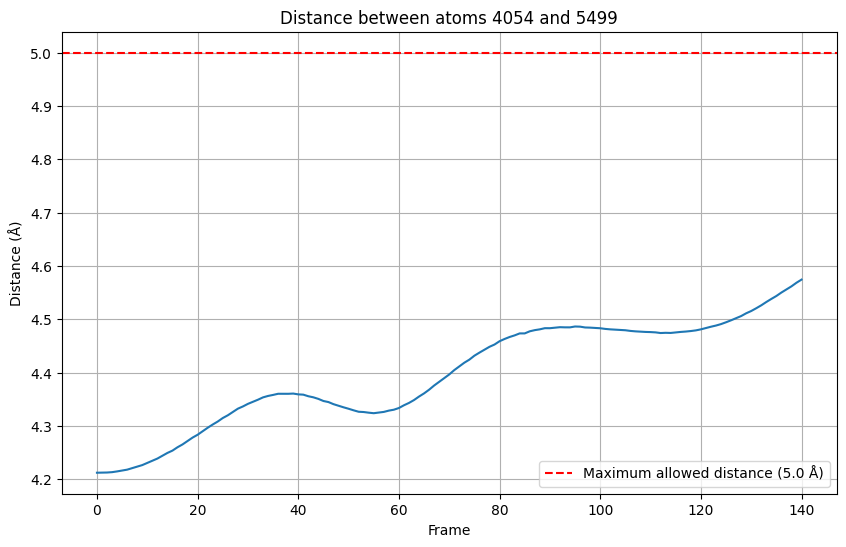

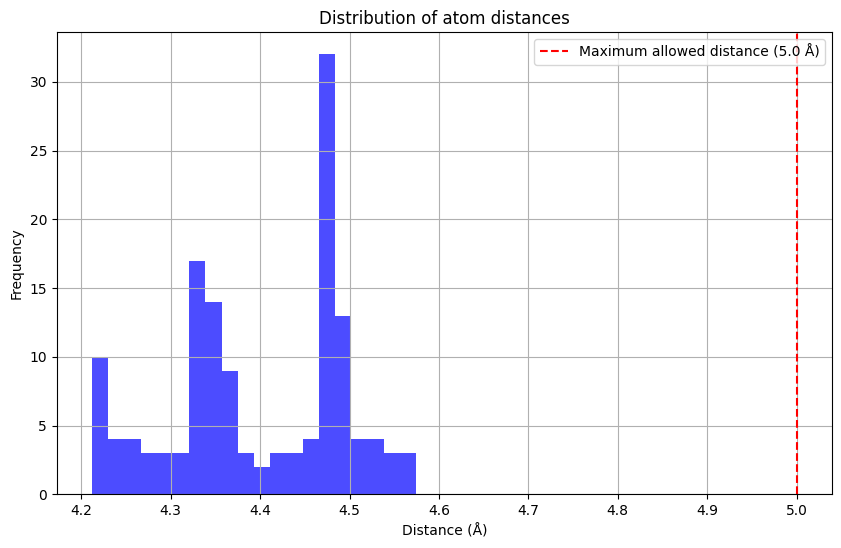

In [ ]:
# 거리 제약 효과 분석
def analyze_distance(trajectory, atom_i=4054, atom_j=5499):
    """두 원자 간 거리 분석"""
    distances = []
    for atoms in trajectory:
        positions = atoms.get_positions()
        vec = positions[atom_j] - positions[atom_i]
        distance = np.linalg.norm(vec)
        distances.append(distance)

    # 거리 통계
    mean_dist = np.mean(distances)
    max_dist = np.max(distances)
    min_dist = np.min(distances)

    print(f"거리 통계:")
    print(f"  평균: {mean_dist:.3f} Å")
    print(f"  최대: {max_dist:.3f} Å")
    print(f"  최소: {min_dist:.3f} Å")

    # 결과 플롯
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.axhline(y=5.0, color='r', linestyle='--', label='Maximum allowed distance (5.0 Å)')
    plt.xlabel('Frame')
    plt.ylabel('Distance (Å)')
    plt.title(f'Distance between atoms {atom_i} and {atom_j}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 히스토그램
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=20, alpha=0.7, color='blue')
    plt.axvline(x=5.0, color='r', linestyle='--', label='Maximum allowed distance (5.0 Å)')
    plt.xlabel('Distance (Å)')
    plt.ylabel('Frequency')
    plt.title('Distribution of atom distances')
    plt.legend()
    plt.grid(True)
    plt.show()

    return distances

# 거리 분석 실행
distances = analyze_distance(trajectory_data, atom_i=4054, atom_j=5499)

# 9. RMSD 분석
단백질 구조의 안정성을 평가하기 위해 RMSD(Root Mean Square Deviation) 분석을 수행할 수 있음

RMSD 통계:
  평균: 0.202 Å
  최대: 0.293 Å


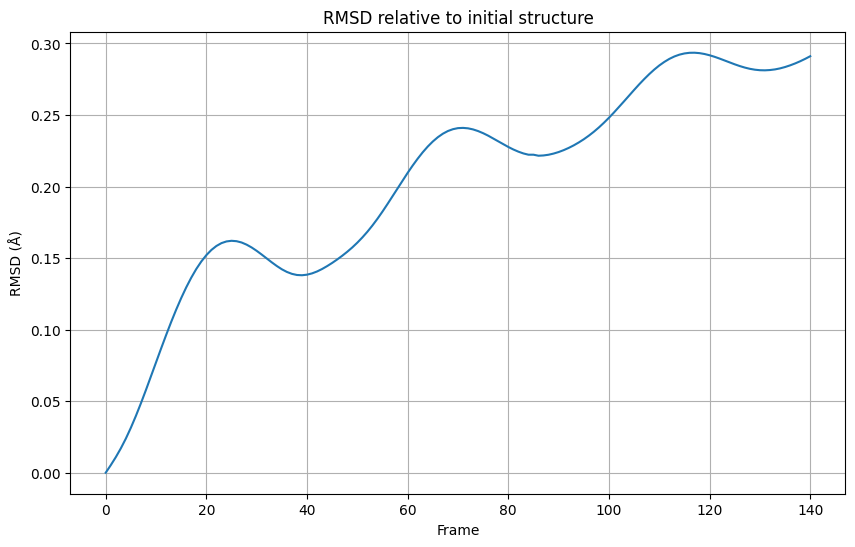

In [ ]:
# RMSD 분석
def calculate_rmsd(trajectory, reference=None, exclude_indices=None):
    if reference is None:
        reference = trajectory[0]

    rmsd_values = []
    for atoms in trajectory:
        # 고정된 원자를 제외한 RMSD 계산
        if exclude_indices:
            positions = atoms.get_positions()
            ref_positions = reference.get_positions()

            # 고정되지 않은 원자 인덱스
            active_indices = [i for i in range(len(atoms)) if i not in exclude_indices]

            # 선택된 원자에 대한 RMSD 계산
            diff = positions[active_indices] - ref_positions[active_indices]
            rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
        else:
            # 모든 원자에 대한 RMSD 계산
            diff = atoms.positions - reference.positions
            rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))

        rmsd_values.append(rmsd)

    # RMSD 통계
    mean_rmsd = np.mean(rmsd_values)
    max_rmsd = np.max(rmsd_values)

    print(f"RMSD 통계:")
    print(f"  평균: {mean_rmsd:.3f} Å")
    print(f"  최대: {max_rmsd:.3f} Å")

    # 결과 플롯
    plt.figure(figsize=(10, 6))
    plt.plot(rmsd_values)
    plt.xlabel('Frame')
    plt.ylabel('RMSD (Å)')
    plt.title('RMSD relative to initial structure')
    plt.grid(True)
    plt.show()

    return rmsd_values

# 고정된 원자 인덱스 로드
with open('frozenatoms.dat', 'r') as f:
    frozen_indices = [int(x) for x in f.read().split()]

# RMSD 분석 실행 (고정 원자 제외)
rmsd_values = calculate_rmsd(trajectory_data, exclude_indices=frozen_indices)

#10. 특정 프레임 분석
특정 프레임(예: 최대 거리가 관찰된 프레임)에서의 구조를 자세히 분석

In [ ]:
# 최대 거리가 관찰된 프레임 분석
max_distance_frame = np.argmax(distances)
print(f"최대 거리 발생 프레임: {max_distance_frame}, 거리: {distances[max_distance_frame]:.3f} Å")

# 해당 프레임 저장
from ase.io import write
write('max_distance_structure.pdb', trajectory_data[max_distance_frame])

# 원자 간 상호작용 분석
def analyze_interactions(atoms, atom_i, atom_j, cutoff=3.5):
    """원자 주변의 상호작용 분석"""
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()

    # 관심 원자 주변 환경 분석
    center_pos = positions[atom_i]
    distances = np.linalg.norm(positions - center_pos, axis=1)

    # 절단 거리 내의 원자 찾기
    nearby_indices = np.where(distances < cutoff)[0]

    print(f"\n{symbols[atom_i]} 원자(인덱스: {atom_i}) 주변 {cutoff}Å 내 원자들:")
    for idx in nearby_indices:
        if idx != atom_i:  # 자기 자신 제외
            dist = distances[idx]
            print(f"  - {symbols[idx]} 원자(인덱스: {idx}), 거리: {dist:.3f} Å")

    # 두 원자 간 거리 계산
    ij_distance = np.linalg.norm(positions[atom_j] - positions[atom_i])
    print(f"\n{symbols[atom_i]}(인덱스: {atom_i})와 {symbols[atom_j]}(인덱스: {atom_j}) 사이 거리: {ij_distance:.3f} Å")

# 최대 거리 프레임에서 상호작용 분석
analyze_interactions(trajectory_data[max_distance_frame], atom_i=4054, atom_j=5499, cutoff=5.0)

최대 거리 발생 프레임: 140, 거리: 4.574 Å

Zn 원자(인덱스: 4054) 주변 5.0Å 내 원자들:
  - C 원자(인덱스: 1409), 거리: 4.092 Å
  - N 원자(인덱스: 1410), 거리: 4.131 Å
  - C 원자(인덱스: 1411), 거리: 2.924 Å
  - C 원자(인덱스: 1412), 거리: 3.016 Å
  - N 원자(인덱스: 1413), 거리: 1.975 Å
  - H 원자(인덱스: 1419), 거리: 2.891 Å
  - H 원자(인덱스: 1420), 거리: 3.385 Å
  - C 원자(인덱스: 1446), 거리: 4.226 Å
  - N 원자(인덱스: 1447), 거리: 4.215 Å
  - C 원자(인덱스: 1448), 거리: 3.021 Å
  - C 원자(인덱스: 1449), 거리: 3.098 Å
  - N 원자(인덱스: 1450), 거리: 2.049 Å
  - H 원자(인덱스: 1456), 거리: 3.133 Å
  - H 원자(인덱스: 1457), 거리: 3.505 Å
  - C 원자(인덱스: 1579), 거리: 4.926 Å
  - O 원자(인덱스: 1580), 거리: 4.037 Å
  - C 원자(인덱스: 1789), 거리: 4.892 Å
  - C 원자(인덱스: 1792), 거리: 3.423 Å
  - C 원자(인덱스: 1793), 거리: 2.942 Å
  - N 원자(인덱스: 1794), 거리: 1.950 Å
  - C 원자(인덱스: 1795), 거리: 4.056 Å
  - C 원자(인덱스: 1796), 거리: 2.927 Å
  - N 원자(인덱스: 1797), 거리: 4.071 Å
  - H 원자(인덱스: 1798), 거리: 4.933 Å
  - H 원자(인덱스: 1800), 거리: 3.108 Å
  - H 원자(인덱스: 1801), 거리: 3.446 Å
  - H 원자(인덱스: 1804), 거리: 3.175 Å
  - H 원자(인덱스: 2153), 거리: 4.885 Å
  - O 원자(인덱스

# 11. 구조 안정성 분석

In [ ]:
# 구조 안정성 분석
def analyze_stability(trajectory, rmsd_values):
    """구조 안정성 분석"""
    # 시뮬레이션 시작과 끝의 구조 비교
    first_frame = trajectory[0]
    last_frame = trajectory[-1]

    # 원자 종류별 RMSD 계산
    atom_symbols = first_frame.get_chemical_symbols()
    unique_symbols = set(atom_symbols)

    print("원자 종류별 RMSD:")
    for symbol in unique_symbols:
        # 해당 원자 종류의 인덱스 찾기
        indices = [i for i, s in enumerate(atom_symbols) if s == symbol]

        # RMSD 계산
        if indices:
            first_pos = first_frame.get_positions()[indices]
            last_pos = last_frame.get_positions()[indices]
            diff = last_pos - first_pos
            symbol_rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
            print(f"  {symbol}: {symbol_rmsd:.3f} Å ({len(indices)}개 원자)")

    # 최종 RMSD 값과 초기 구조 비교
    final_rmsd = rmsd_values[-1]
    print(f"\n최종 프레임 RMSD: {final_rmsd:.3f} Å")

    # 안정성 판단 (예: RMSD < 2.0 Å을 안정적으로 간주)
    if final_rmsd < 2.0:
        print("구조가 안정적으로 유지되었습니다.")
    else:
        print("구조에 상당한 변화가 있었습니다.")

# 구조 안정성 분석 실행
analyze_stability(trajectory_data, rmsd_values)

원자 종류별 RMSD:
  O: 0.089 Å (863개 원자)
  H: 0.193 Å (2967개 원자)
  N: 0.072 Å (352개 원자)
  C: 0.075 Å (1316개 원자)
  Zn: 0.218 Å (1개 원자)
  S: 0.181 Å (2개 원자)

최종 프레임 RMSD: 0.291 Å
구조가 안정적으로 유지되었습니다.
